<a href="https://colab.research.google.com/github/DimpleB0501/AiScholarshipCodes/blob/master/MNISTwithPytorchAndColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing libraries

In [0]:
!pip3 install numpy
!pip3 install torch torchvision
!pip3 install matplotlib

#Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import optim

In [0]:
print ("Pytorch version:", torch.__version__)

Pytorch version: 1.1.0


# Select GPU mode

In [0]:
# Check if GPU available
if torch.cuda.is_available():
  print ("On GPU")
else :
  print ("No GPU available")

On GPU


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading MNIST dataset


In [0]:
# Define a transform to normalize the data
trainTransform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5, )),
                              ])

# Use the same transform for the validation data
validTransform = trainTransform

# Download and load the training data
trainSet = MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=trainTransform)
validSet = MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=validTransform)

0it [00:00, ?it/s]

9920512it [00:00, 29110640.39it/s]                           


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 457870.39it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145592.42it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7135076.58it/s]                            
8192it [00:00, 174784.00it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
print (trainSet.train_data.shape)
print (validSet.test_data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


# Print training images and their labels

In [0]:
def plotImages (X, labels):
  #Plot the first 5 images and their labels
  for i, (img, y) in enumerate(zip(X, labels)):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


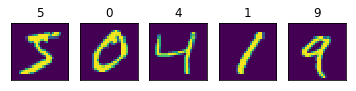

In [0]:
plotImages (trainSet.train_data[:5], trainSet.train_labels[:5].numpy())

In [0]:
trainLoader = DataLoader(trainSet, batch_size=256, num_workers=0, shuffle=True)
validLoader = DataLoader(validSet, batch_size=512, num_workers=0, shuffle=False)

# Utilites

In [0]:
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

# Progress monitor

In [0]:
from IPython.display import HTML, display

class ProgressMonitor(object):
    """
    Custom IPython progress bar for training
    """
    
    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

#Lenet architecture

In [0]:
class LeNet(torch.nn.Module):
     
  def __init__(self):   
        super(LeNet, self).__init__()
        # Convolution (In LeNet, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = torch.nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
  def forward(self, out):
        # convolve, then perform ReLU non-linearity
        out = torch.nn.functional.relu(self.conv1(out))  
        # max-pooling with 2x2 grid
        out = self.max_pool_1(out)
        # convolve, then perform ReLU non-linearity
        out = torch.nn.functional.relu(self.conv2(out))
        # max-pooling with 2x2 grid
        out = self.max_pool_2(out)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        out = out.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        out = torch.nn.functional.relu(self.fc1(out))
        # FC-2, then perform ReLU non-linearity
        out = torch.nn.functional.relu(self.fc2(out))
        # FC-3
        out = self.fc3(out)
        
        return out

# Instantiate the model and move it to CUDA device

In [0]:
model = LeNet ()
model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Train the model

In [0]:
#criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [0]:
def train(optimizer, model, num_epochs=10, first_epoch=1):
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    valid_losses = []

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)

        # train phase
        model.train()

        # create a progress bar
        progress = ProgressMonitor(length=len(trainSet))

        train_loss = MovingAverage()

        for batch, targets in trainLoader:
            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
            optimizer.zero_grad()

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer.step()

            # update average loss
            train_loss.update(loss)

            # update progress bar
            progress.update(batch.shape[0], train_loss)

        print('Training loss:', train_loss)
        train_losses.append(train_loss.value)


        # validation phase
        model.eval()

        valid_loss = RunningAverage()

        # keep track of predictions
        y_pred = []

        # We don't need gradients for validation, so wrap in 
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in validLoader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                predictions = model(batch)

                # calculate the loss
                loss = criterion(predictions, targets)

                # update running loss value
                valid_loss.update(loss)

                # save predictions
                y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

        print('Validation loss:', valid_loss)
        valid_losses.append(valid_loss.value)

        # Calculate validation accuracy
        y_pred = torch.tensor(y_pred, dtype=torch.int64)
        accuracy = torch.mean((y_pred == validSet.test_labels).float())
        print('Validation accuracy: {:.4f}%'.format(float(accuracy) * 100))

        # Save a checkpoint
        #checkpoint_filename = 'checkpoints/mnist-{:03d}.pkl'.format(epoch)
        #save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        if epoch == 10:
          torch.save(model, 'mnistTrain.pth')
    
    return train_losses, valid_losses, y_pred

In [0]:
train_losses, valid_losses, y_pred = train(optimizer, model, num_epochs=10)

Epoch 1


Training loss: 0.3664
Validation loss: 0.0694
Validation accuracy: 97.5900%
Epoch 2


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Training loss: 0.0659
Validation loss: 0.0527
Validation accuracy: 98.3400%
Epoch 3


Training loss: 0.0434
Validation loss: 0.0381
Validation accuracy: 98.7400%
Epoch 4


Training loss: 0.0349
Validation loss: 0.0519
Validation accuracy: 98.3600%
Epoch 5


Training loss: 0.0328
Validation loss: 0.0416
Validation accuracy: 98.7000%
Epoch 6


Training loss: 0.0255
Validation loss: 0.0341
Validation accuracy: 98.9100%
Epoch 7


Training loss: 0.0224
Validation loss: 0.0358
Validation accuracy: 98.8800%
Epoch 8


Training loss: 0.0196
Validation loss: 0.0368
Validation accuracy: 98.7700%
Epoch 9


Training loss: 0.0173
Validation loss: 0.0322
Validation accuracy: 99.0800%
Epoch 10


Training loss: 0.0158
Validation loss: 0.0418
Validation accuracy: 98.9100%


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#Test on a random Image from the validation set

In [0]:
device = 'cuda'
model=torch.load('mnistTrain.pth')
model.eval()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

tensor([[ -635.4801,  -837.5001,    32.4767,   531.2853,  -714.0096,   145.5402,
          -671.1224, -1334.0713,  1527.1113,   172.6783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[8]], device='cuda:0')


	 Predicted Label: 8


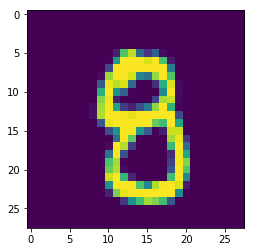

In [0]:
%matplotlib inline

loadedImg = validLoader.dataset.data[2512] # Change value in the box to test on different images
plt.imshow(loadedImg)
loadedImg = loadedImg.to(device)
loadedImg = loadedImg[None, None]
loadedImg = loadedImg.type('torch.cuda.FloatTensor') # instead of DoubleTensor

out_predict = model(loadedImg)
print (out_predict)
pred = out_predict.max(1, keepdim=True)[1]
print (pred)
print ('\n')
print("\t Predicted Label:", pred.item())